## Basics


In [1]:
# imports
import numpy as np

import commstools.plotting as plotting
from commstools import set_backend, get_backend
from commstools.dsp.filtering import rrc_taps
from commstools.dsp.sequences import prbs
from commstools.waveforms import ook
import time

t1 = time.time()

set_backend("gpu")


/home/lokgar/commstools/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Let's start with generating a bit sequence which will represent the data we want to transmit.

In [2]:
# Generate a Pseudo-Random Binary Sequence (PRBS)
bits = prbs(length=2**22, order=31, seed=0x30F1CA55)

print("First Generated 20 bits:", bits[:20])
print("Mean value: ", bits.mean())


First Generated 20 bits: [1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0]
Mean value:  0.5333328247070312


Let's define base system parameters and map the bits to an OOK signal.

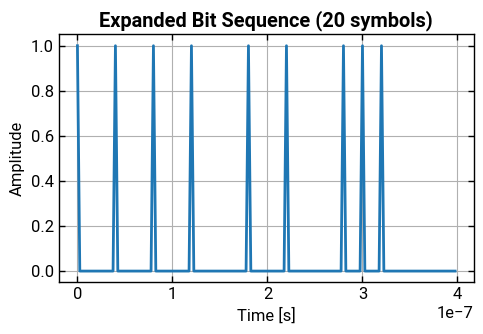

In [3]:
# Define system parameters
symbol_rate = 50e6
sampling_rate = 400e6
sps = int(sampling_rate / symbol_rate)
rrc_rolloff = 0.1

sig_impulse = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="none")

sig_impulse.plot_signal(
    num_symbols=20, show=True, title="Expanded Bit Sequence (20 symbols)"
)


Now, let's pulse shape the signal to get the actual waveform.

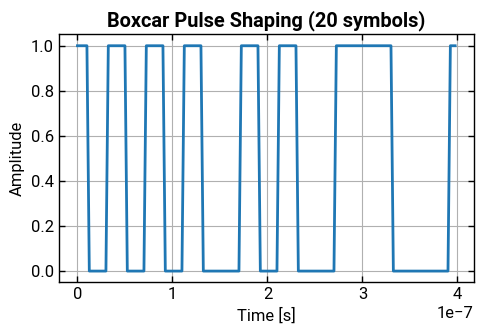

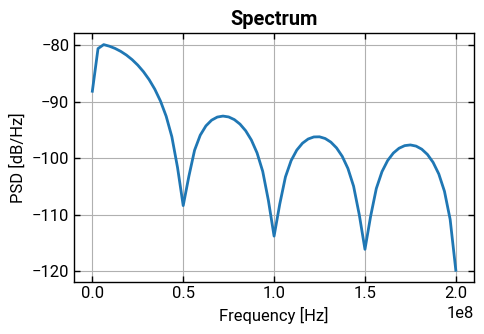

In [4]:
# Boxcar (rectangular) pulse shaping
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="boxcar")

sig_boxcar.plot_signal(
    num_symbols=20, show=True, title="Boxcar Pulse Shaping (20 symbols)"
)
sig_boxcar.plot_psd(show=True, title="Spectrum")


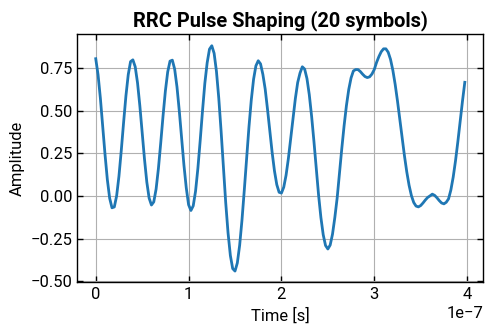

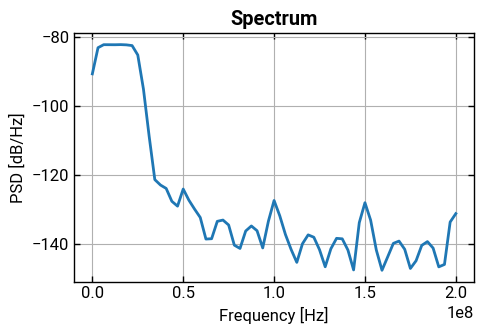

In [5]:
# RRC pulse shaping
sig_rrc = ook(
    bits,
    sampling_rate=sampling_rate,
    sps=sps,
    pulse_shape="rrc",
    filter_span=18,
    rrc_rolloff=rrc_rolloff,
)

sig_rrc.plot_signal(num_symbols=20, show=True, title="RRC Pulse Shaping (20 symbols)")
sig_rrc.plot_psd(show=True, title="Spectrum")


Let's investigate the RRC filter we applied.

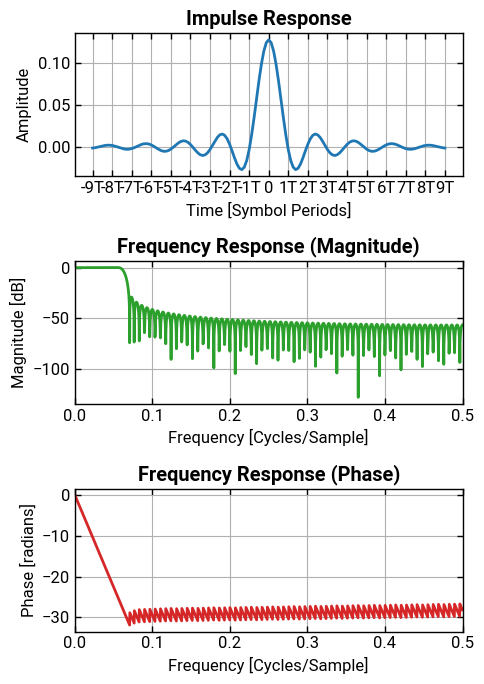

In [6]:
# Create the same RRC filter
rrc_filter = rrc_taps(sps=sps, rolloff=rrc_rolloff, span=18)

# Plot the filter response
plotting.filter_response(rrc_filter, sps, show=True)


Let's add some noise to the signal for naive representation of distorted signal on the receiver.

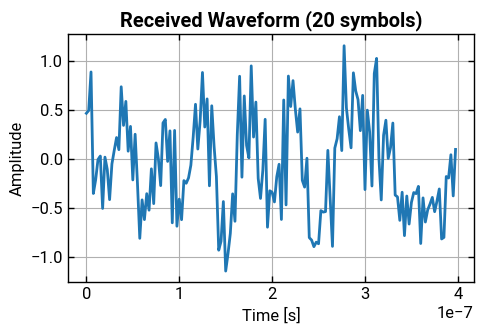

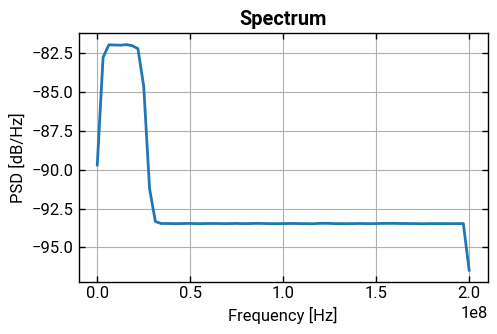

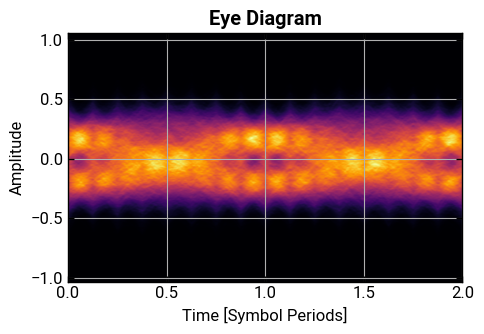

In [7]:
noise = 0.3 * np.random.randn(*sig_rrc.samples.shape)
from commstools.core.backend import ensure_on_backend

noise = ensure_on_backend(noise)
sig_rrc.samples = sig_rrc.samples + noise


sig_rrc.plot_signal(num_symbols=20, show=True, title="Received Waveform (20 symbols)")
sig_rrc.plot_psd(show=True, title="Spectrum")
sig_rrc.plot_eye(plot_type="hist", show=True, cmap="inferno")


Now we can check what happens on the receiver side.
As the pulse shape is RRC, we need to use a matched filter with the same RRC shape at the receiver.

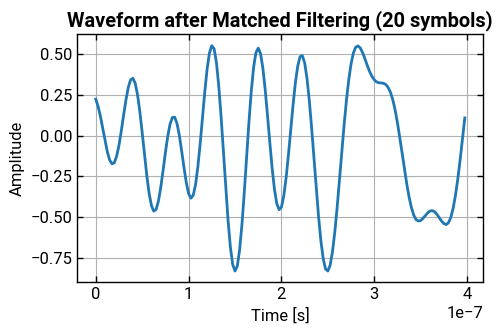

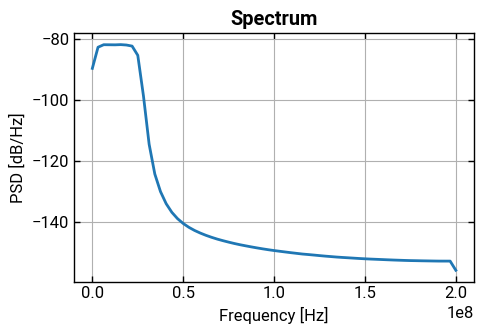

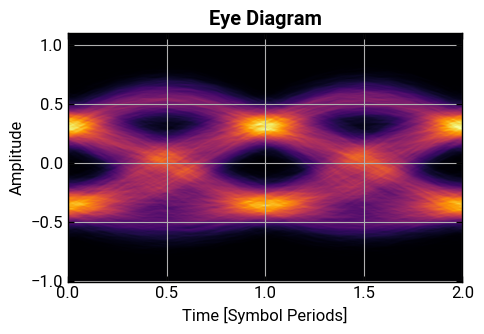

In [8]:
sig_rrc.matched_filter(
    pulse_taps=rrc_filter, taps_normalization="unity_gain", normalize_output=False
)

sig_rrc.plot_signal(
    num_symbols=20, show=True, title="Waveform after Matched Filtering (20 symbols)"
)
sig_rrc.plot_psd(show=True, title="Spectrum")
sig_rrc.plot_eye(plot_type="hist", show=True, cmap="inferno")


In [9]:
print("Total time: ", time.time() - t1)


Total time:  4.3465821743011475


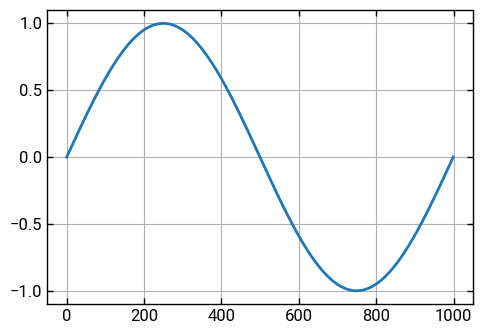

In [10]:
import cupy as cp

import matplotlib.pyplot as plt

a = cp.sin(cp.linspace(0, 2 * cp.pi, 1000))
plt.plot(a.get())
plt.show()


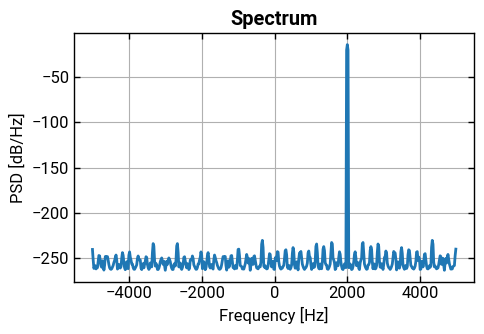

In [11]:
# generate complex signal
import numpy as np

fs = 10000  # Sampling frequency (Hz)
f = 2000  # Signal frequency (Hz)
duration = 100  # seconds
t = np.arange(0, duration, 1 / fs)  # Time vector
complex_signal = np.exp(1j * 2 * np.pi * f * t)

from commstools.plotting import psd

psd(complex_signal, fs, nperseg=510, show=True)
